In [54]:
from collections import Counter
from copy import deepcopy
import datetime
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import seaborn as sns
import scipy.interpolate as intrp
import scipy.signal as sig
import scipy.stats as st
from skimage.filters import threshold_otsu

import Objectives.Electrophysiology.ephys_objs as epo
import Objectives.Electrophysiology.ephys_util as epu

import Utility.ABF_util as abf
import Utility.DataIO_util as DIO
import Utility.runfile_util as rfu
import Utility.utility as utl

In [2]:
plt.close('all')

sns.set({'legend.frameon':True}, color_codes=True)
matplotlib.rc("font", size=20)
matplotlib.rc("xtick", labelsize=16)
matplotlib.rc("ytick", labelsize=16)
matplotlib.rc("axes", labelsize=20)
matplotlib.rc("axes", titlesize=24)
matplotlib.rc("legend", fontsize=18)
matplotlib.rc("figure", titlesize=24)

In [3]:
figDir = "./Figures/FlourakisDataReview/"

infoDir = "./Runfiles/RedCheck_Overview/"

infoDict = rfu.getInfo(infoDir, verbose=1)

dataDir = DIO.get_data_dir(dataDir="")

Loading info from ./Runfiles/RedCheck_Overview/


2011_04_01_0015.abf
Recorded at 13:51:27:760
File has 2 channels
There are 62000 data points per channel
The channels are:
	Vm_scaled	(mV)
	I_output	(pA)
There are 10 episodes
2011_04_01_0000.abf
Recorded at 12:38:50:432
File has 2 channels
There are 62000 data points per channel
The channels are:
	Vm_scaled	(mV)
	I_output	(pA)
There are 1 episodes


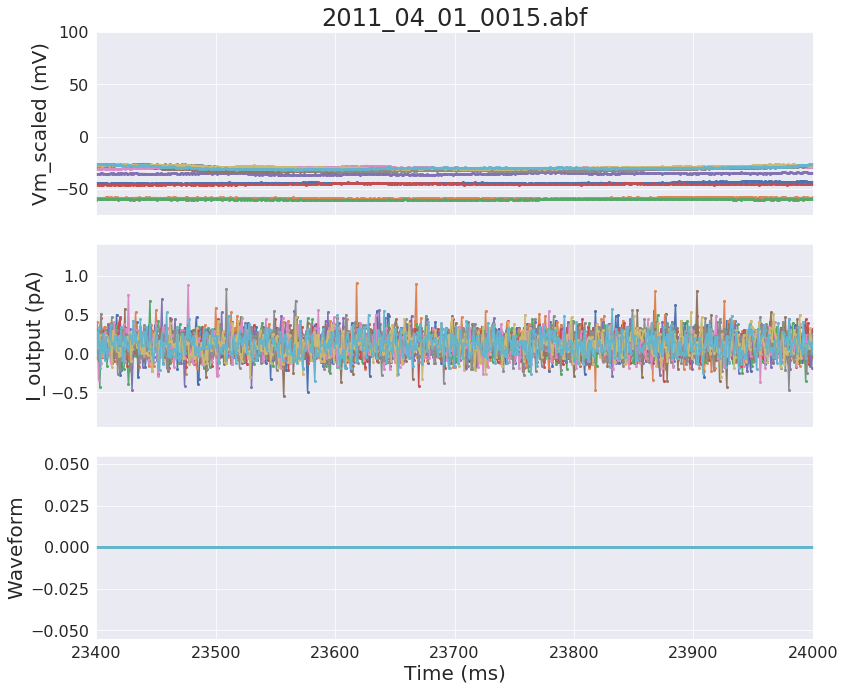

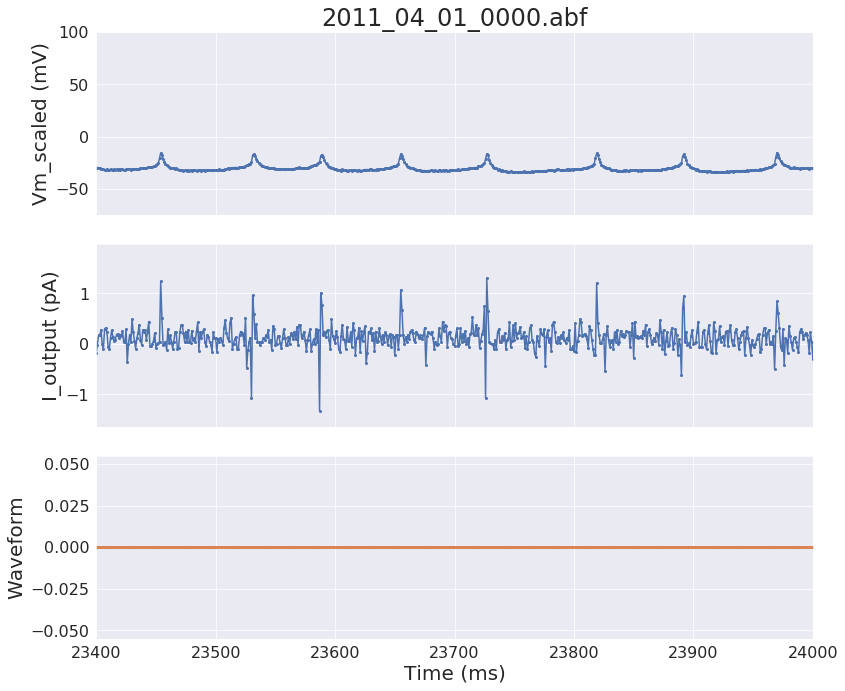

In [22]:
year = '2011'
month = 'April 2011'
day = '04012011'

fileDir = os.path.join(dataDir, year, month, day)
fileList = sorted(os.listdir(fileDir))
for file in fileList:
    if 'abf' not in file:
        continue

    if "15.abf" not in file:
        continue

    print(file)

    [d, h] = abf.ABF_read(file, datadir=fileDir)

    hour = int(h['lFileStartTime']/3600)
    mins = int((h['lFileStartTime'] - hour*3600)/60)
    secs = int(h['lFileStartTime'] % 60)
    msec = int((h['lFileStartTime'] - int(h['lFileStartTime']))*1000)

    print(f"Recorded at {hour:02d}:{mins:02d}:{secs:02d}:{msec:03d}")
    print(f"File has {h['nADCNumChannels']} channels")
    print(f"There are {h['dataPtsPerChan']} data points per channel")
    print(f"The channels are:")
    for name, unit in zip(h['recChNames'], h['recChUnits']):
        print(f"\t{name}\t({unit})")
    print(f"There are {h['lActualEpisodes']} episodes")

    timebase = abf.GetTimebase(h, 0)

    fig, axes = plt.subplots(h['nADCNumChannels']+1, 1, 
        figsize=(12,10), sharex=True)

    for chan in range(h['nADCNumChannels']):
        ax = axes[chan]

        name = h['recChNames'][chan]
        unit = h['recChUnits'][chan]

        ax.plot(timebase, d[:, chan], '-o', ms=2)
        ax.set_ylabel(f"{name} ({unit})")

    ax = axes[-1]
    for chan in range(h['lActualEpisodes']):
        waveform = abf.GetWaveform(h, chan+1)
        ax.plot(timebase, waveform, '-o', ms=2)

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Waveform")
          
    axes[0].set_ylim(-75, 100)
    axes[0].set_xlim(23400, 24000)

    axes[0].set_title(file)

    fig.tight_layout()
          
data15 = d.copy()
hdr15 = h.copy()

##### ALSO LOAD File 00!          
year = '2011'
month = 'April 2011'
day = '04012011'

fileDir = os.path.join(dataDir, year, month, day)
fileList = sorted(os.listdir(fileDir))
for file in fileList:
    if 'abf' not in file:
        continue

    if "00.abf" not in file:
        continue

    print(file)

    [d, h] = abf.ABF_read(file, datadir=fileDir)

    hour = int(h['lFileStartTime']/3600)
    mins = int((h['lFileStartTime'] - hour*3600)/60)
    secs = int(h['lFileStartTime'] % 60)
    msec = int((h['lFileStartTime'] - int(h['lFileStartTime']))*1000)

    print(f"Recorded at {hour:02d}:{mins:02d}:{secs:02d}:{msec:03d}")
    print(f"File has {h['nADCNumChannels']} channels")
    print(f"There are {h['dataPtsPerChan']} data points per channel")
    print(f"The channels are:")
    for name, unit in zip(h['recChNames'], h['recChUnits']):
        print(f"\t{name}\t({unit})")
    print(f"There are {h['lActualEpisodes']} episodes")

    timebase = abf.GetTimebase(h, 0)

    fig, axes = plt.subplots(h['nADCNumChannels']+1, 1, 
        figsize=(12,10), sharex=True)

    for chan in range(h['nADCNumChannels']):
        ax = axes[chan]

        name = h['recChNames'][chan]
        unit = h['recChUnits'][chan]

        ax.plot(timebase, d[:, chan], '-o', ms=2)
        ax.set_ylabel(f"{name} ({unit})")

    ax = axes[-1]
    for chan in range(h['lActualEpisodes']):
        waveform = abf.GetWaveform(h, chan+1)
        ax.plot(timebase, waveform, '-o', ms=2)

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Waveform")
          
    axes[0].set_ylim(-75, 100)
    axes[0].set_xlim(23400, 24000)

    axes[0].set_title(file)

    fig.tight_layout()
                    
data00 = d.copy()
hdr00 = h.copy()

In [52]:
data = data15[:, 0, :]

d0 = data[:, 0].squeeze()
d10 = data[:, -1].squeeze()

d = data00[:, 0, :].squeeze()

dt = 0.001
maxRate = 100.
exact = True
pad = 1
minSlope = 20.

maxSpikeLen = .1 ## s
window = 2 * maxSpikeLen / dt
# window = 300

verbose = 5

minISI = int(1./dt/maxRate)
window = window + 1 if ((window % 2) == 0) else window

noMed = d - epu.getRollPerc(d, window=window, perc=50, verbose=verbose)
noMed0 = d0 - epu.getRollPerc(d0, window=window, perc=50, verbose=verbose)
noMed10 = d10 - epu.getRollPerc(d10, window=window, perc=50, verbose=verbose)

20/201: 19, 21
40/201: 39, 41
60/201: 59, 61
80/201: 79, 81
100/201: 99, 101
120/201: 119, 121
140/201: 139, 141
160/201: 159, 161
180/201: 179, 181
200/201: 199, 201
20/201: 19, 21
40/201: 39, 41
60/201: 59, 61
80/201: 79, 81
100/201: 99, 101
120/201: 119, 121
140/201: 139, 141
160/201: 159, 161
180/201: 179, 181
200/201: 199, 201
20/201: 19, 21
40/201: 39, 41
60/201: 59, 61
80/201: 79, 81
100/201: 99, 101
120/201: 119, 121
140/201: 139, 141
160/201: 159, 161
180/201: 179, 181
200/201: 199, 201


In [50]:
sIdx, sVals = epo.getSpikeIdx(d, dt=dt, verbose=verbose)
sIdx0, sVals0 = epo.getSpikeIdx(d0, dt=dt, verbose=verbose)
sIdx10, sVals10 = epo.getSpikeIdx(d10, dt=dt, verbose=verbose)

Getting Exact (non-integer) Spike Locations!
20/101: 19, 21
40/101: 39, 41
60/101: 59, 61
80/101: 79, 81
100/101: 99, 101
Finding minimum allowable wlen
Starting with T =	5.035mV
P =	7.477mV
Otsu Thr: 14.33 (410 on left 577 on right)
Low Median 13.73, High Median 14.95

987 Spikes Found!
wlen for min slope = 375
Otsu Thr: 14.33 (410 on left 577 on right)
Low Median 13.73, High Median 14.95

987 Spikes Found!
wLen_MinSlope yields same no. of spikes as wLen_Max!
Determined that the minimal spike width is 375
Otsu Thr: 14.33 (410 on left 577 on right)
Low Median 13.73, High Median 14.95
987 Peaks Found...
Thresh = 5.035	Prom = 7.477	wLen = 375
Itr:	WL - PEAK - WR - Width
0:	Adjust 15 - 17 - 21 - 6
1:	Adjust 53 - 55 - 59 - 6
3:	Adjust 159 - 162 - 166 - 7
4:	Adjust 219 - 221 - 225 - 6
5:	Adjust 285 - 288 - 291 - 6
6:	Adjust 354 - 357 - 360 - 6
7:	Adjust 424 - 424 - 424 - 0
7:	Adjust 423 - 424 - 425 - 2
9:	Adjust 545 - 548 - 551 - 6
10:	Adjust 606 - 608 - 612 - 6
11:	Adjust 661 - 664 - 668 -

396:	Adjust 24741 - 24744 - 24747 - 6
397:	Adjust 24812 - 24814 - 24818 - 6
399:	Adjust 24937 - 24939 - 24943 - 6
400:	Adjust 25023 - 25026 - 25029 - 6
402:	Adjust 25173 - 25175 - 25179 - 6
403:	Adjust 25226 - 25229 - 25232 - 6
404:	Adjust 25282 - 25285 - 25288 - 6
405:	Adjust 25339 - 25342 - 25345 - 6
406:	Adjust 25416 - 25419 - 25422 - 6
407:	Adjust 25464 - 25467 - 25470 - 6
408:	Adjust 25532 - 25534 - 25538 - 6
411:	Adjust 25710 - 25712 - 25716 - 6
412:	Adjust 25778 - 25780 - 25784 - 6
413:	Adjust 25829 - 25832 - 25835 - 6
414:	Adjust 25905 - 25908 - 25911 - 6
415:	Adjust 25994 - 25997 - 26000 - 6
416:	Adjust 26049 - 26052 - 26055 - 6
417:	Adjust 26121 - 26123 - 26127 - 6
418:	Adjust 26181 - 26183 - 26187 - 6
419:	Adjust 26249 - 26251 - 26255 - 6
420:	Adjust 26321 - 26324 - 26327 - 6
421:	Adjust 26378 - 26380 - 26384 - 6
423:	Adjust 26494 - 26497 - 26500 - 6
425:	Adjust 26629 - 26631 - 26635 - 6
426:	Adjust 26705 - 26708 - 26711 - 6
427:	Adjust 26751 - 26753 - 26757 - 6
428:	Adjust 

948:	Adjust 59220 - 59223 - 59226 - 6
950:	Adjust 59345 - 59348 - 59351 - 6
951:	Adjust 59435 - 59438 - 59441 - 6
954:	Adjust 59628 - 59630 - 59634 - 6
955:	Adjust 59680 - 59683 - 59686 - 6
957:	Adjust 59821 - 59823 - 59827 - 6
958:	Adjust 59867 - 59869 - 59874 - 7
959:	Adjust 59926 - 59930 - 59934 - 8
960:	Adjust 60004 - 60006 - 60010 - 6
961:	Adjust 60047 - 60050 - 60054 - 7
966:	Adjust 60386 - 60388 - 60392 - 6
968:	Adjust 60541 - 60544 - 60547 - 6
969:	Adjust 60640 - 60643 - 60646 - 6
971:	Adjust 60769 - 60771 - 60775 - 6
972:	Adjust 60815 - 60818 - 60822 - 7
973:	Adjust 60911 - 60913 - 60918 - 7
974:	Adjust 60952 - 60955 - 60960 - 8
975:	Adjust 61041 - 61044 - 61047 - 6
976:	Adjust 61150 - 61152 - 61156 - 6
977:	Adjust 61203 - 61206 - 61209 - 6
978:	Adjust 61295 - 61297 - 61301 - 6
979:	Adjust 61362 - 61365 - 61368 - 6
980:	Adjust 61443 - 61445 - 61449 - 6
982:	Adjust 61617 - 61620 - 61623 - 6
984:	Adjust 61750 - 61752 - 61756 - 6
985:	Adjust 61832 - 61835 - 61838 - 6
Getting Exac

(53000, 55000)

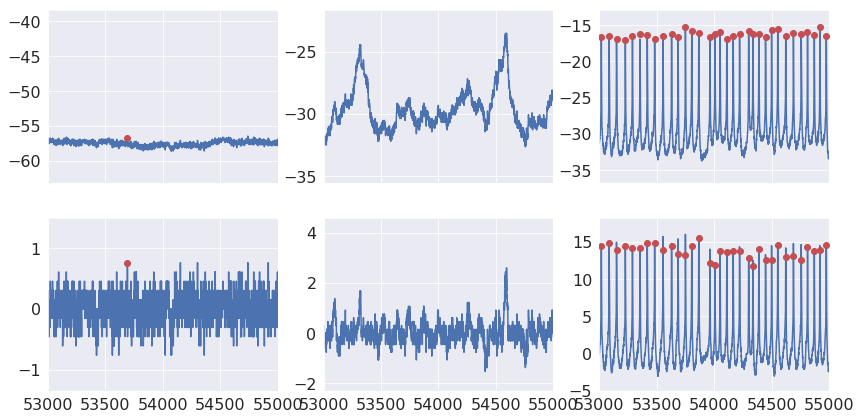

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True)

axes[0, 0].plot(timebase, d0)
axes[0, 0].scatter(sIdx0, sVals0, c='r', zorder=10)

axes[1, 0].plot(timebase, noMed0)
axes[1, 0].scatter(sIdx0, noMed0[sIdx0.astype(int)+1], c='r', zorder=10)

axes[0, 1].plot(timebase, d10)
axes[0, 1].scatter(sIdx10, sVals10, c='r', zorder=10)

axes[1, 1].plot(timebase, noMed10)
axes[1, 1].scatter(sIdx10, noMed10[sIdx10.astype(int)+1], c='r', zorder=10)

axes[0, 2].plot(timebase, d)
axes[0, 2].scatter(sIdx, sVals, c='r', zorder=10)

axes[1, 2].plot(timebase, noMed)
axes[1, 2].scatter(sIdx, noMed[sIdx.astype(int)+1], c='r', zorder=10)

axes[1, 0].set_xlim(53000, 55000)

In [56]:
## Rec 0 Ep 0
dCnts = Counter(noMed.ravel())
dVals = np.msort(list(dCnts.keys()))
dCDF = np.cumsum(np.asarray([dCnts[ii] for ii in dVals]))
dCDF = dCDF/dCDF[-1]

## Rec 15 Ep 0
dCnts0 = Counter(noMed0.ravel())
dVals0 = np.msort(list(dCnts0.keys()))
dCDF0 = np.cumsum(np.asarray([dCnts0[ii] for ii in dVals0]))
dCDF0 = dCDF0/dCDF0[-1]

## Rec 15 Ep 10
dCnts10 = Counter(noMed10.ravel())
dVals10 = np.msort(list(dCnts10.keys()))
dCDF10 = np.cumsum(np.asarray([dCnts10[ii] for ii in dVals10]))
dCDF10 = dCDF10/dCDF10[-1]

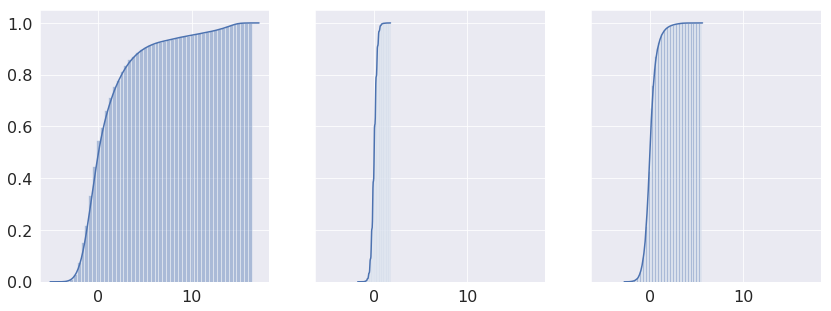

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True, sharex=True)

sns.distplot(noMed, ax=ax[0], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),)

sns.distplot(noMed0, ax=ax[1], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),)

sns.distplot(noMed10, ax=ax[2], hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),)

In [191]:
promArr = dVals[dCDF >= .02]
pPromArr = dCDF[dCDF >= 0.02]
promArr0 = dVals0[dCDF0 >= .02]
pPromArr0 = dCDF0[dCDF0 >= 0.02]
promArr10 = dVals10[dCDF10 >= .02]
pPromArr10 = dCDF10[dCDF10 >= 0.02]

In [192]:
wLenMax0 = len(d)
wLenMax15 = len(d0)

# wLen_MinSlope = int(np.ceil(minProm/minSlope/dt))
# if wLen_MinSlope % 2 == 0:
#     wLen_MinSlope += 1

thresh = np.percentile(noMed, 50)
promAdj = np.percentile(noMed, 1)

NPeaks = np.zeros((len(promArr), 3))
for ii, prom in enumerate(promArr):
    peakIdx, _ = sig.find_peaks(noMed, height=thresh, prominence=prom-promAdj, wlen=wLenMax0, distance=minISI)
    NPeaks[ii, 0] = len(peakIdx)
    
    wLenMin = int(np.ceil((prom-promAdj)/minSlope/dt))
    if wLenMin % 2 == 0:
        wLenMin += 1
        
    peakIdx, _ = sig.find_peaks(noMed, height=thresh, prominence=prom-promAdj, wlen=wLenMin, distance=minISI)
    NPeaks[ii, 1] = len(peakIdx)
        
    peakIdx, _ = sig.find_peaks(noMed, height=thresh, prominence=prom-promAdj, wlen=3, distance=minISI)
    NPeaks[ii, 2] = len(peakIdx)
    
#     print(prom, wLenMax0, wLenMin, NPeaks[ii])
    
thresh0 = np.percentile(noMed0, 50)
promAdj0 = np.percentile(noMed0, 1)

NPeaks0 = np.zeros((len(promArr0), 3))
for ii, prom in enumerate(promArr0):
    peakIdx, _ = sig.find_peaks(noMed0, height=thresh0, prominence=prom-promAdj0, wlen=wLenMax15, distance=minISI)
    NPeaks0[ii, 0] = len(peakIdx)
    
    wLenMin = int(np.ceil((prom-promAdj0)/minSlope/dt))
    if wLenMin % 2 == 0:
        wLenMin += 1
        
    peakIdx, _ = sig.find_peaks(noMed0, height=thresh, prominence=prom-promAdj0, wlen=wLenMin, distance=minISI)
    NPeaks0[ii, 1] = len(peakIdx)
        
    peakIdx, _ = sig.find_peaks(noMed0, height=thresh, prominence=prom-promAdj0, wlen=3, distance=minISI)
    NPeaks0[ii, 2] = len(peakIdx)
    
    print(prom, wLenMax0, wLenMin, NPeaks0[ii])    

    
thresh10 = np.percentile(noMed10, 50)
promAdj10 = np.percentile(noMed10, 1)

NPeaks10 = np.zeros((len(promArr10), 3))
for ii, prom in enumerate(promArr10):
    peakIdx, _ = sig.find_peaks(noMed10, height=thresh10, prominence=prom-promAdj10, wlen=wLenMax15, distance=minISI)
    NPeaks10[ii, 0] = len(peakIdx)
    
    wLenMin = int(np.ceil((prom-promAdj10)/minSlope/dt))
    if wLenMin % 2 == 0:
        wLenMin += 1
        
    peakIdx, _ = sig.find_peaks(noMed10, height=thresh, prominence=prom-promAdj10, wlen=wLenMin, distance=minISI)
    NPeaks10[ii, 1] = len(peakIdx)
        
    peakIdx, _ = sig.find_peaks(noMed10, height=thresh, prominence=prom-promAdj10, wlen=3, distance=minISI)
    NPeaks10[ii, 2] = len(peakIdx)
    
#     print(prom-promAdj10, wLenMax0, wLenMin, NPeaks10[ii]) 

/home/emj760/anaconda2/envs/MOO_CNM/lib/python3.7/site-packages/ipykernel_launcher.py:23: PeakPropertyWarning: some peaks have a prominence of 0
/home/emj760/anaconda2/envs/MOO_CNM/lib/python3.7/site-packages/ipykernel_launcher.py:43: PeakPropertyWarning: some peaks have a prominence of 0


-0.6103515335098564 62000 9 [4311. 4311. 3770.]
-0.4577636501324065 62000 17 [4188. 4181. 2251.]
-0.4577636501323994 62000 17 [4188. 4181. 2251.]
-0.4577636501323923 62000 17 [4188. 4181. 2251.]
-0.3051757667549424 62000 23 [3901. 3861.  942.]
-0.3051757667549353 62000 23 [3901. 3861.  942.]
-0.3051757667549282 62000 23 [3901. 3861.  942.]
-0.1525878833774783 62000 31 [3336. 3267.  281.]
-0.1525878833774712 62000 31 [3336. 3267.  281.]
-0.1525878833774641 62000 31 [3336. 3267.  281.]
0.0 62000 39 [2443. 2212.   50.]
0.1525878833774641 62000 47 [1564. 1131.    8.]
0.1525878833774712 62000 47 [1156.  573.    3.]
0.1525878833774783 62000 47 [1.008e+03 3.980e+02 1.000e+00]
0.3051757667549282 62000 55 [974. 436.   1.]
0.3051757667549353 62000 55 [721. 228.   1.]
0.3051757667549424 62000 55 [640. 141.   0.]
0.4577636501323923 62000 63 [607. 142.   0.]
0.4577636501323994 62000 63 [464.  82.   0.]
0.4577636501324065 62000 63 [410.  47.   0.]
0.6103515335098564 62000 69 [393.  45.   0.]
0.61035

/home/emj760/anaconda2/envs/MOO_CNM/lib/python3.7/site-packages/ipykernel_launcher.py:64: PeakPropertyWarning: some peaks have a prominence of 0


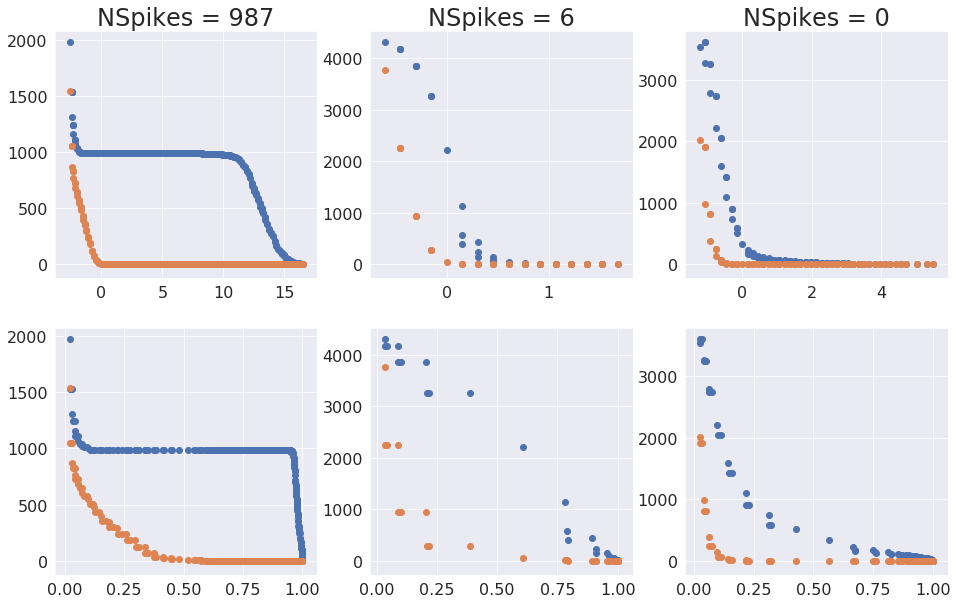

In [199]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

# ax[0, 0].scatter(promArr, NPeaks[:, 0])
ax[0, 0].scatter(promArr, NPeaks[:, 1])
ax[0, 0].scatter(promArr, NPeaks[:, 2])

ax[0, 0].set_title(f"NSpikes = {len(sIdx)}")

# ax[1, 0].scatter(pPromArr, NPeaks[:, 0])
ax[1, 0].scatter(pPromArr, NPeaks[:, 1])
ax[1, 0].scatter(pPromArr, NPeaks[:, 2])

# ax[0, 1].scatter(promArr0, NPeaks0[:, 0])
ax[0, 1].scatter(promArr0, NPeaks0[:, 1])
ax[0, 1].scatter(promArr0, NPeaks0[:, 2])

ax[0, 1].set_title(f"NSpikes = {len(sIdx0)}")

# ax[1, 1].scatter(pPromArr0, NPeaks0[:, 0])
ax[1, 1].scatter(pPromArr0, NPeaks0[:, 1])
ax[1, 1].scatter(pPromArr0, NPeaks0[:, 2])


# ax[0, 2].scatter(promArr10, NPeaks10[:, 0])
ax[0, 2].scatter(promArr10, NPeaks10[:, 1])
ax[0, 2].scatter(promArr10, NPeaks10[:, 2])

# ax[0, 2].set_ylim(-10, 10)

ax[0, 2].set_title(f"NSpikes = {len(sIdx10)}")

# ax[1, 2].scatter(pPromArr10, NPeaks10[:, 0])
ax[1, 2].scatter(pPromArr10, NPeaks10[:, 1])
ax[1, 2].scatter(pPromArr10, NPeaks10[:, 2])

In [194]:
## Number of peaks at each prominence
pkCntsMinS = NPeaks[:, 1].astype(int)

## Difference in the number of peaks from one prominence to next
np.diff(pkCntsMinS)

## Prominences at which peak numbers change
whereCntDiffs = promArr[1:][np.diff(pkCntsMinS).nonzero()]

## Peak numbers at which peak numbers change
wherePNsDiff = pkCntsMinS[1:][np.diff(pkCntsMinS).nonzero()]

## Differences between prominences at which peaks change, including end points of prominence array.
diffPromArr = np.diff(np.array([promArr[0]] + list(promArr[1:][np.diff(pkCntsMinS).nonzero()]) + [promArr[-1]]))

## Index of Max Prominence Difference
maxPromDiffIdx = np.where(diffPromArr == diffPromArr.max())[0][-1]

print(f"Max Prom Diff is {diffPromArr.max():.4f} at {whereCntDiffs[maxPromDiffIdx-1]:.4f} "
      +f"to {whereCntDiffs[maxPromDiffIdx]:.4f} " 
      +f"corresponding to {wherePNsDiff[maxPromDiffIdx]:d} peaks!")

Max Prom Diff is 9.4604 at -1.2207 to 8.2397 corresponding to 986 peaks!


In [195]:
pkCntsMinS10 = NPeaks10[:, 1].astype(int)

## Difference in the number of peaks from one prominence to next
np.diff(pkCntsMinS10)

## Prominences at which peak numbers change
whereCntDiffs10 = promArr10[1:][np.diff(pkCntsMinS10).nonzero()]
## Peak numbers at which peak numbers change
wherePNsDiff10 = pkCntsMinS10[1:][np.diff(pkCntsMinS10).nonzero()]

## Differences between prominences at which peaks change, including end points of prominence array.
diffPromArr10 = np.diff(np.array([promArr10[0]] +
                                 list(promArr10[1:][np.diff(pkCntsMinS10).nonzero()]) +
                                 [promArr10[-1]]))

## Index of Max Prominence Difference
maxPromDiffIdx10 = np.where(diffPromArr10 == diffPromArr10.max())[0][-1]

print(f"Max Prom Diff is {diffPromArr10.max():.4f} at {whereCntDiffs10[maxPromDiffIdx10-1]:.4f} "
      +f"to {whereCntDiffs10[maxPromDiffIdx10]:.4f} " 
      +f"corresponding to {wherePNsDiff10[maxPromDiffIdx10]:d} peaks!")

Max Prom Diff is 1.8311 at 3.5095 to 5.3406 corresponding to 0 peaks!


In [196]:
pkCntsMinS0 = NPeaks0[:, 1].astype(int)

## Difference in the number of peaks from one prominence to next
np.diff(pkCntsMinS0)

## Prominences at which peak numbers change
whereCntDiffs0 = promArr0[1:][np.diff(pkCntsMinS0).nonzero()]
## Peak numbers at which peak numbers change
wherePNsDiff0 = pkCntsMinS0[1:][np.diff(pkCntsMinS0).nonzero()]

## Differences between prominences at which peaks change, including end points of prominence array.
diffPromArr0 = np.diff(np.array([promArr0[0]] +
                                 list(promArr0[1:][np.diff(pkCntsMinS0).nonzero()]) +
                                 [promArr0[-1]]))

## Index of Max Prominence Difference
maxPromDiffIdx0 = np.where(diffPromArr0 == diffPromArr0.max())[0][-1]

print(f"Max Prom Diff is {diffPromArr0.max():.4f} at {whereCntDiffs0[maxPromDiffIdx0-1]:.4f} "
      +f"to {whereCntDiffs0[maxPromDiffIdx0]:.4f} " 
      +f"corresponding to {wherePNsDiff0[maxPromDiffIdx0]:d} peaks!")

Max Prom Diff is 0.1526 at 1.3733 to 1.5259 corresponding to 1 peaks!


In [224]:
thresh = np.percentile(noMed, 50)
promAdj = np.percentile(noMed, 1)

NWLen = 20
wLenArr = np.arange(3, 305, 20).astype(int)
NWLen = len(wLenArr)

NPeaks = np.zeros((len(promArr), NWLen))
for ii, prom in enumerate(promArr):
    
    wLenMin = int(np.ceil((prom-promAdj)/minSlope/dt))
    if wLenMin % 2 == 0:
        wLenMin += 1
        
#     wLenArr = np.linspace(3, wLenMin, NWLen).astype(int)
#     wLenArr = np.array([wl + 1  if ((wl % 2) == 0) else wl for wl in wLenArr])
    
    for jj, wLen in enumerate(wLenArr):
        
        if wLen > wLenMin:
            wLen = wLenMin

        peakIdx, _ = sig.find_peaks(noMed, height=thresh, prominence=prom-promAdj, wlen=wLen, distance=minISI)
        NPeaks[ii, jj] = len(peakIdx)
    
    print(ii, prom, wLenMin, wLenArr)

/home/emj760/anaconda2/envs/MOO_CNM/lib/python3.7/site-packages/ipykernel_launcher.py:23: PeakPropertyWarning: some peaks have a prominence of 0


0 -2.593994017416893 17 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
1 -2.441406134039436 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
2 -2.4414061340394326 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
3 -2.441406134039429 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
4 -2.4414061340394255 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
5 -2.288818250661972 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
6 -2.2888182506619685 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
7 -2.288818250661965 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
8 -2.2888182506619614 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
9 -2.136230367284508 39 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
10 -2.1362303672845044 39 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
11 -

99 2.441406134039436 269 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
100 2.593994017416893 275 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
101 2.5939940174168967 275 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
102 2.5939940174169003 275 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
103 2.7465819007943573 283 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
104 2.746581900794361 283 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
105 2.7465819007943644 283 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
106 2.8991697841718214 291 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
107 2.899169784171825 291 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
108 2.8991697841718285 291 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
109 3.0517576675492855 299 [  3  23  43  63  83 103 123 143 163 183 203 223

195 8.087157819005615 551 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
196 8.087157819005618 551 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
197 8.239745702383079 557 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
198 8.239745702383082 557 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
199 8.239745702383086 557 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
200 8.392333585760543 565 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
201 8.392333585760547 565 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
202 8.544921469138007 573 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
203 8.54492146913801 573 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
204 8.544921469138014 573 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
205 8.697509352515471 581 [  3  23  43  63  83 103 123 143 163 183 203 223 243 26

292 13.885497387349261 841 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
293 13.885497387349265 841 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
294 13.885497387349266 841 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
295 14.038085270726725 847 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
296 14.038085270726729 847 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
297 14.190673154104193 855 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
298 14.190673154104196 855 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
299 14.343261037481657 863 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
300 14.34326103748166 863 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
301 14.495848920859121 871 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
302 14.495848920859125 871 [  3  23  43  63  83 103 123 143 163 183 203

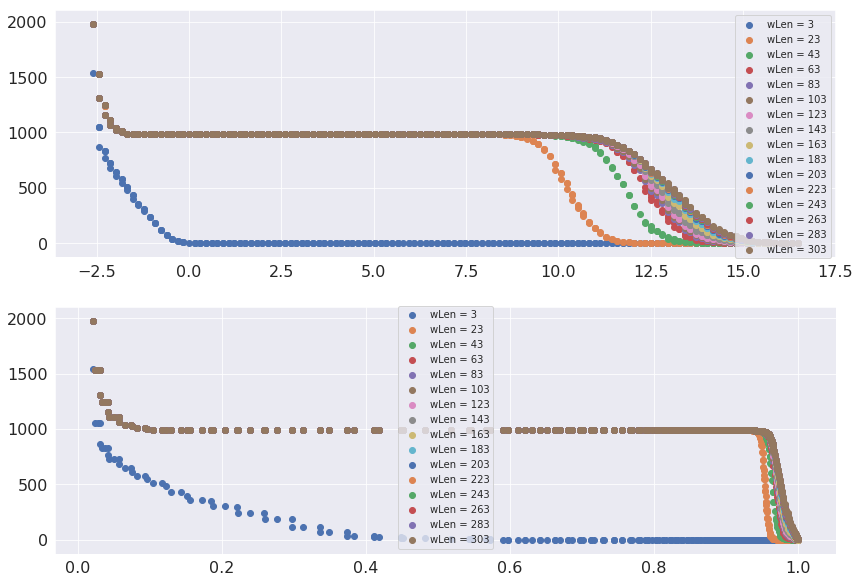

In [225]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

for ii in range(NWLen):
    ax[0].scatter(promArr, NPeaks[:, ii], label=f'wLen = {wLenArr[ii]:d}')
ax[0].legend(fontsize=10)
    
for ii in range(NWLen):
    ax[1].scatter(pPromArr, NPeaks[:, ii], label=f'wLen = {wLenArr[ii]:d}')
ax[1].legend(fontsize=10)  

In [222]:
thresh10 = np.percentile(noMed10, 50)
promAdj10 = np.percentile(noMed10, 1)

NWLen10 = 20
wLenArr10 = np.arange(3, 305, 20).astype(int)
NWLen10 = len(wLenArr10)

NPeaks10 = np.zeros((len(promArr10), NWLen10))
for ii, prom in enumerate(promArr10):
    
    wLenMin = int(np.ceil((prom-promAdj10)/minSlope/dt))
    if wLenMin % 2 == 0:
        wLenMin += 1
    
    for jj, wLen in enumerate(wLenArr10):
        
        if wLen > wLenMin:
            wLen = wLenMin
        
        peakIdx, _ = sig.find_peaks(noMed10, height=thresh, prominence=prom-promAdj10, wlen=wLen, distance=minISI)
        NPeaks10[ii, jj] = len(peakIdx)
    
    print(ii, prom-promAdj10, wLenMin, wLenArr)

/home/emj760/anaconda2/envs/MOO_CNM/lib/python3.7/site-packages/ipykernel_launcher.py:23: PeakPropertyWarning: some peaks have a prominence of 0


0 0.15258788337746765 9 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
1 0.30517576675492464 17 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
2 0.3051757667549282 17 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
3 0.30517576675493174 17 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
4 0.45776365013238873 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
5 0.4577636501323923 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
6 0.45776365013239584 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
7 0.6103515335098528 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
8 0.6103515335098564 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
9 0.6103515335098599 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
10 0.7629394168873169 39 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
11 0.

96 6.408691101853506 321 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
97 6.713866868608434 337 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
98 6.866454751985902 345 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]


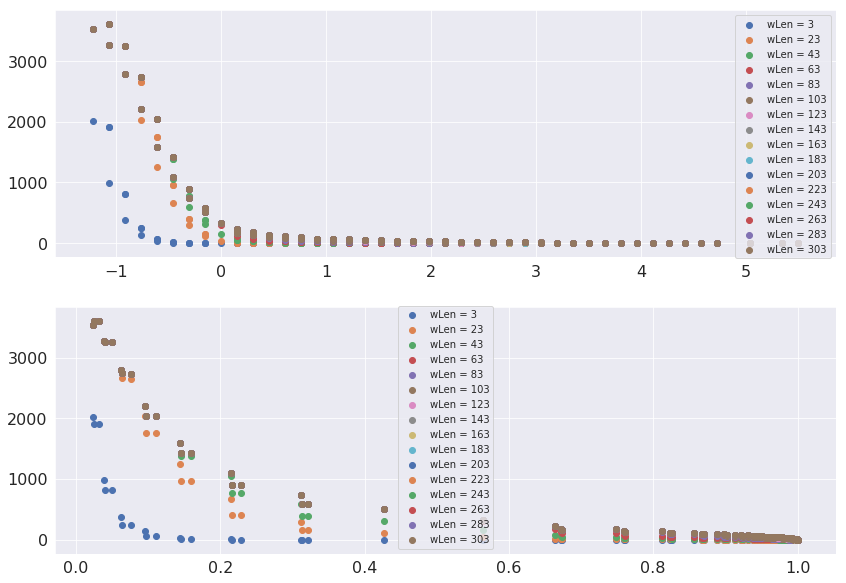

In [223]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

for ii in range(NWLen10):
    ax[0].scatter(promArr10, NPeaks10[:, ii], label=f'wLen = {wLenArr10[ii]:d}')
ax[0].legend(fontsize=10)
    
for ii in range(NWLen10):
    ax[1].scatter(pPromArr10, NPeaks10[:, ii], label=f'wLen = {wLenArr10[ii]:d}')
ax[1].legend(fontsize=10)  

In [226]:
thresh0 = np.percentile(noMed0, 50)
promAdj0 = np.percentile(noMed0, 1)

NWLen0 = 20
wLenArr0 = np.arange(3, 305, 20).astype(int)
NWLen0 = len(wLenArr0)

NPeaks0 = np.zeros((len(promArr0), NWLen0))
for ii, prom in enumerate(promArr0):
    
    wLenMin = int(np.ceil((prom-promAdj0)/minSlope/dt))
    if wLenMin % 2 == 0:
        wLenMin += 1
        
#     wLenArr = np.linspace(3, wLenMin, NWLen).astype(int)
#     wLenArr = np.array([wl + 1  if ((wl % 2) == 0) else wl for wl in wLenArr])
    
    for jj, wLen in enumerate(wLenArr0):
        
        if wLen > wLenMin:
            wLen = wLenMin
        
        peakIdx, _ = sig.find_peaks(noMed0, height=thresh, prominence=prom-promAdj0, wlen=wLen, distance=minISI)
        NPeaks0[ii, jj] = len(peakIdx)
    
    print(ii, prom-promAdj0, wLenMin, wLenArr)

/home/emj760/anaconda2/envs/MOO_CNM/lib/python3.7/site-packages/ipykernel_launcher.py:23: PeakPropertyWarning: some peaks have a prominence of 0


0 0.1525878833774641 9 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
1 0.305175766754914 17 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
2 0.3051757667549211 17 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
3 0.3051757667549282 17 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
4 0.4577636501323781 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
5 0.4577636501323852 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
6 0.4577636501323923 23 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
7 0.6103515335098422 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
8 0.6103515335098493 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
9 0.6103515335098564 31 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
10 0.7629394168873205 39 [  3  23  43  63  83 103 123 143 163 183 203 223 243 263 283 303]
11 0.915527

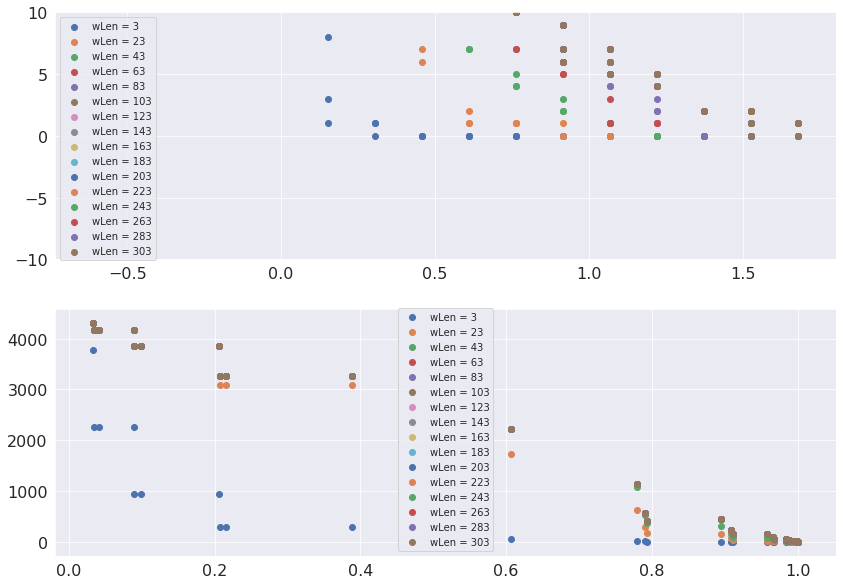

In [228]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

for ii in range(NWLen10):
    ax[0].scatter(promArr0, NPeaks0[:, ii], label=f'wLen = {wLenArr0[ii]:d}')
ax[0].legend(fontsize=10)

ax[0].set_ylim(-10, 10)
    
for ii in range(NWLen10):
    ax[1].scatter(pPromArr0, NPeaks0[:, ii], label=f'wLen = {wLenArr0[ii]:d}')
ax[1].legend(fontsize=10)  